In [ ]:

pip install lime

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the trained XGBoost model
model_path = '/content/drive/My Drive/IDS data sets/XGboost.pkl'
xgb_model = joblib.load(model_path)

# Load your dataset for explainability (use the test dataset)
test_data = pd.read_csv('/content/drive/My Drive/IDS data sets/NF-BoT-IoT-V2_5000 samples_minmax_normalized_test.csv')

# Separate features and labels
X_test = test_data.iloc[:, :-1]  # All columns except the last two (labels)
y_test = test_data.iloc[:, -1]    # Last column (label names)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:27:44] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Display the number of NaN values per column in X_train and X_test

print("\nNaN values in each column of X_test:")
print(X_test.isna().sum())

# Drop columns with any NaN values from X_train and X_test
#X_train = X_train.dropna(axis=1)
X_test = X_test.dropna(axis=1)


NaN values in each column of X_test:
L4_SRC_PORT                       0
L4_DST_PORT                       0
PROTOCOL                          0
L7_PROTO                          0
IN_BYTES                          0
IN_PKTS                           0
OUT_BYTES                         0
OUT_PKTS                          0
TCP_FLAGS                         0
CLIENT_TCP_FLAGS                  0
SERVER_TCP_FLAGS                  0
FLOW_DURATION_MILLISECONDS        0
DURATION_IN                       0
DURATION_OUT                      0
MIN_TTL                           0
MAX_TTL                           0
LONGEST_FLOW_PKT                  0
SHORTEST_FLOW_PKT                 0
MIN_IP_PKT_LEN                    0
MAX_IP_PKT_LEN                    0
SRC_TO_DST_SECOND_BYTES           0
DST_TO_SRC_SECOND_BYTES           0
RETRANSMITTED_IN_BYTES            0
RETRANSMITTED_IN_PKTS             0
RETRANSMITTED_OUT_BYTES           0
RETRANSMITTED_OUT_PKTS            0
SRC_TO_DST_AVG_THROUGHPUT 

In [ ]:
 #SHAP Explainability
# Initialize SHAP explainer using TreeExplainer (specific to tree-based models like XGBoost)
explainer = shap.TreeExplainer(xgb_model)
# محاسبه مقادیر shap برای مجموعه تست
shap_values = explainer.shap_values(X_test)

In [ ]:
class_names = y_test.unique()  # Get unique values from the target variable
class_names

array(['DDoS', 'DoS', 'Reconnaissance', 'Benign'], dtype=object)

4


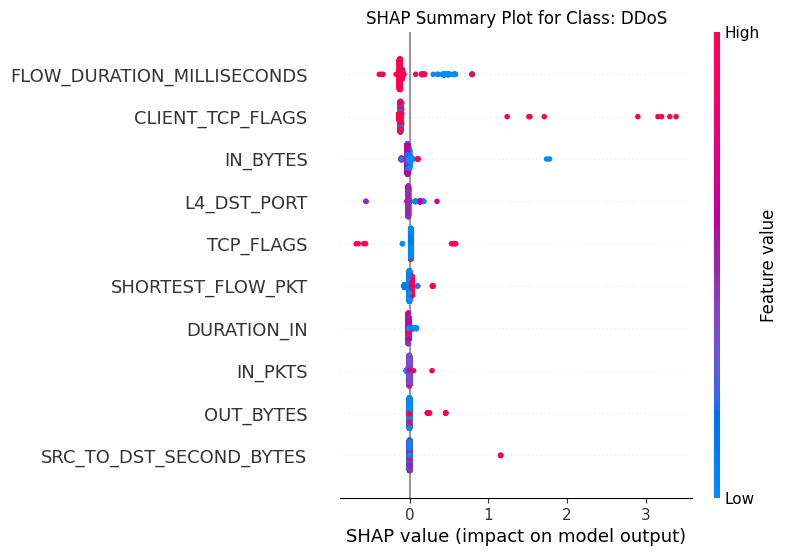

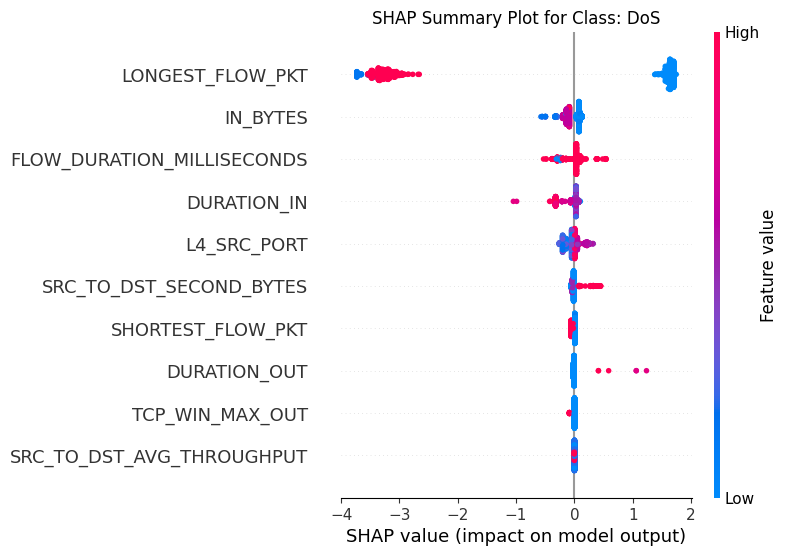

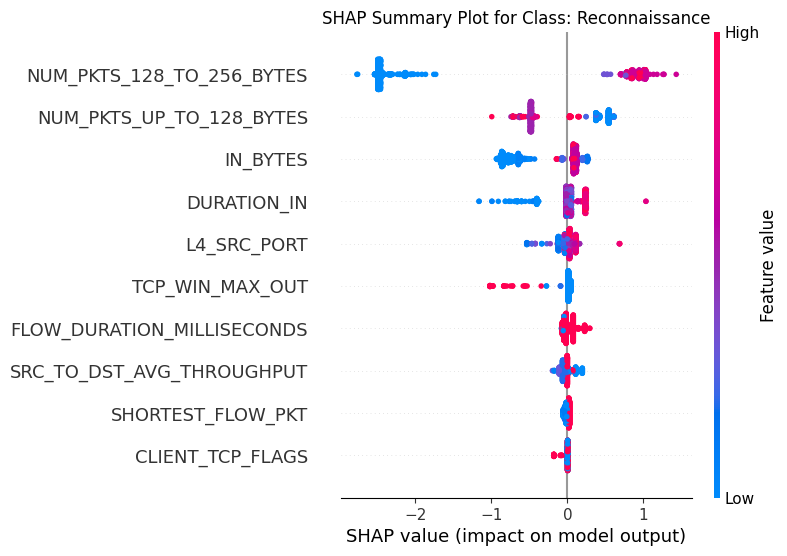

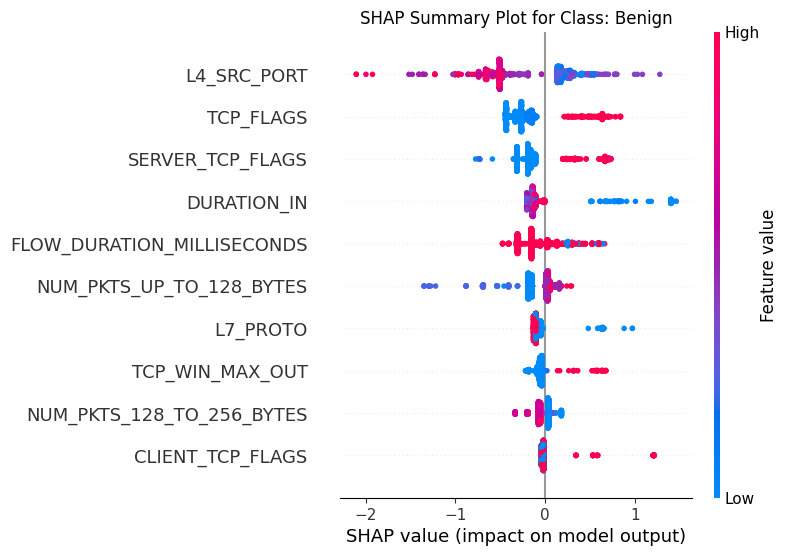

In [ ]:
import matplotlib.pyplot as plt

# Plotting with adjusted figure size
num_classes = shap_values.shape[2] -1
print(num_classes)
for class_index in range(num_classes):
    shap_values_class = shap_values[:, :, class_index]

    # Set figure size before plotting
    plt.figure(figsize=(10, 6))  # Adjust width and height as needed


    shap.summary_plot(shap_values_class, X_test, feature_names=X_test.columns,
                      max_display=10, show=False)
    class_name = class_names[class_index]
    plt.title(f"SHAP Summary Plot for Class: {class_name}")

In [ ]:
import os
# Define directory to save SHAP values and datasets
save_dir = '/content/drive/My Drive/SHAP_saved_NF_BoT_IoT_V2'  # Ensure this directory exists in your Google Drive

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Define paths to save SHAP values and datasets
shap_values_path = os.path.join(save_dir, 'shap_values.pkl')
X_test_path = os.path.join(save_dir, 'X_test.pkl')
y_test_path = os.path.join(save_dir, 'y_test.pkl')
explainer_path = os.path.join(save_dir, 'shap_explainer.pkl')


In [ ]:
# Save SHAP values, X_test, y_test, and explainer
joblib.dump(shap_values, shap_values_path)
joblib.dump(X_test, X_test_path)
joblib.dump(y_test, y_test_path)
joblib.dump(explainer, explainer_path)

print("Saved SHAP values, explainer, and datasets successfully.")

Saved SHAP values, explainer, and datasets successfully.


In [ ]:
# LIME Explainability
# Initialize LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_test),
    feature_names=X_test.columns,
    class_names=np.unique(y_test),
    mode='classification'
)

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

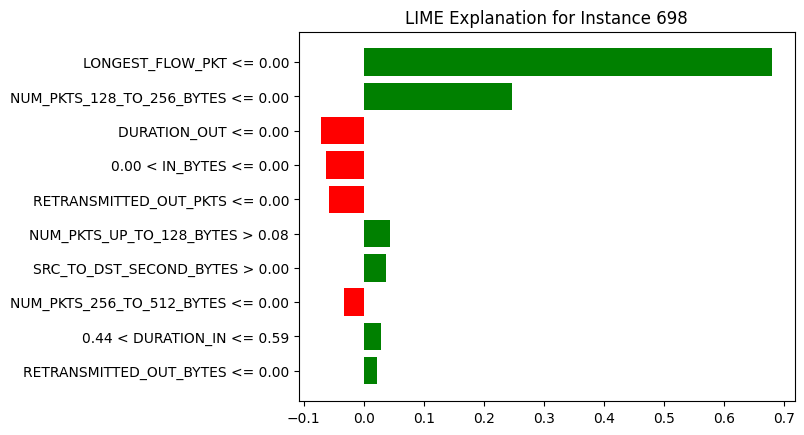

In [ ]:
# Choose an instance to explain (for example, the first instance)
instance_to_explain = X_test.iloc[698]

# Generate LIME explanation
lime_exp = lime_explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=xgb_model.predict_proba
)

# Plot LIME explanation for the selected instance
lime_exp.as_pyplot_figure()
plt.title('LIME Explanation for Instance 698')
plt.show()